In [1]:
import tensorflow as tf
from tensorflow import keras

from collections import Counter
import numpy as np
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pandas as pd
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
#!pip install focal_loss
from focal_loss import SparseCategoricalFocalLoss
import os,shutil
from keras.preprocessing.image import ImageDataGenerator

# Hipotesis #16

 Considere problemas de clasificación con clases bastante desbalanceadas en que nos interesa obtener un desempeño parejo entre las diferentes clases. El método de aumentar el peso de los errores sobre las clases minoritarias es menos efectivo que adoptar la función de error denominada focal loss.

# Dataset 1

In [14]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path="mnist.npz")

In [16]:
mask  = y_train == 1
mask1 = y_train == 7
mask2 = y_train == 2

x_train = x_train[mask | mask1 | mask2]
y_train = y_train[mask | mask1 | mask2]

mask  = y_test == 1
mask1 = y_test == 7
mask2 = y_test == 2 
    
x_test = x_test[mask | mask1 | mask2]
y_test = y_test[mask | mask1 | mask2]

In [17]:
def UnderSample(X, y, labels, under_label, freq):
    
    xs = []
    ys = []
    
    
    for label in labels:
        mask =  y == label
        _y = y[mask]
        _x = X[mask]
        
        if(under_label == label):
            
            to_use = y.shape[0] * freq
            pct = to_use / _y.shape[0]
            
            rand_mask = np.random.choice([0, 1], _y.shape[0], p=[1-pct, pct]).astype(bool)
            _x = _x[rand_mask]
            _y = _y[rand_mask]
        
        xs.append(_x)
        ys.append(_y)
        
    X2 = np.concatenate(xs)
    y2 = np.concatenate(ys)
    
    return shuffle(X2, y2, random_state=0)   
        
    
print(Counter(y_test), Counter(y_train))                      
                      
X, y = UnderSample(x_train, y_train, labels = [1, 7, 2], under_label = 7, freq = .05)
X_test,  y_test  = UnderSample(x_test, y_test, labels = [1, 7, 2], under_label = 7, freq = .05)

print(Counter(y_test), Counter(y))

Counter({1: 1135, 2: 1032, 7: 1028}) Counter({1: 6742, 7: 6265, 2: 5958})
Counter({1: 1135, 2: 1032, 7: 175}) Counter({1: 6742, 2: 5958, 7: 916})


# Desbalance de clases

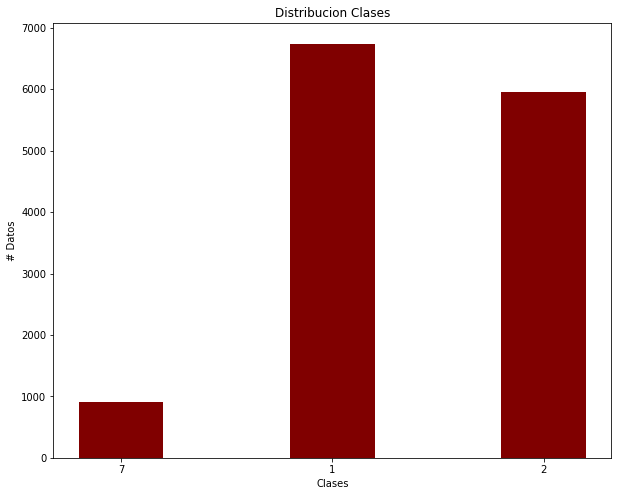

In [18]:
fig = plt.figure(figsize=(10, 8))
plt.bar([str(x) for x in Counter(y).keys()], Counter(y).values(), color ='maroon',
        width = 0.4)
plt.xlabel("Clases")
plt.ylabel("# Datos")
plt.title("Distribucion Clases")
plt.show()

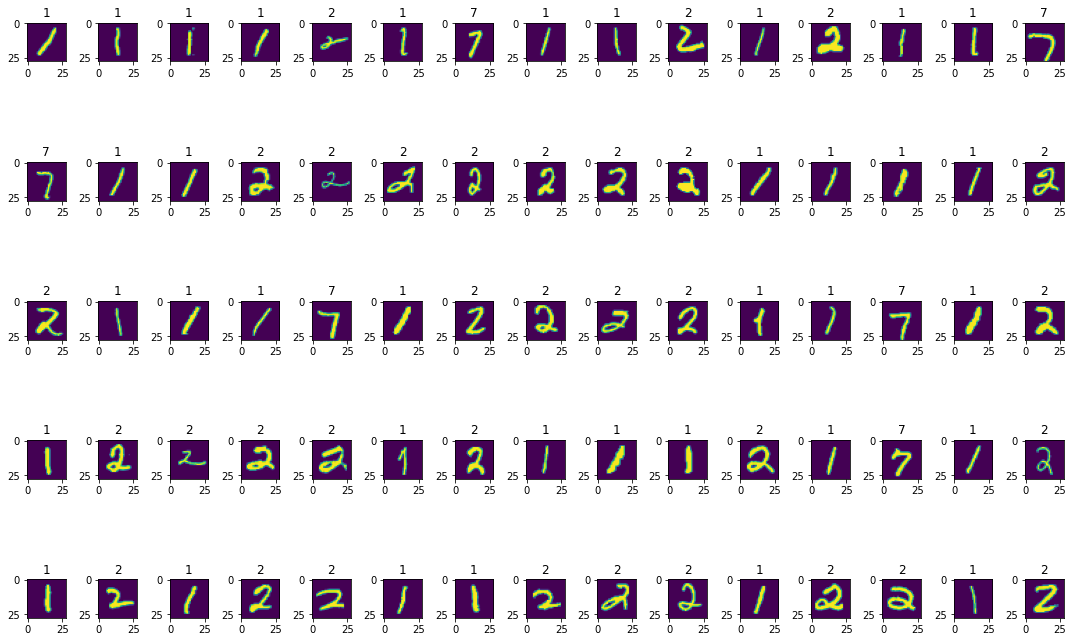

In [19]:
fig = plt.figure(figsize=(15, 10))
columns = 15
rows = 5
for i in range(1, columns*rows +1):
    img = X[i*4]
    fig.add_subplot(rows, columns, i)
    plt.title(y[i*4])
    plt.imshow(img)
fig.tight_layout()
plt.show()

# Encode de clases

In [20]:
y[y == 1] = 0
y[y == 7] = 1
y[y == 2] = 2

In [21]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = .2, stratify=y)

## Calculando Pesos de Clases

In [22]:
class_weight = compute_class_weight(class_weight ='balanced', classes = np.unique(y_train), y = y_train)
class_w = {0: class_weight[0], 1: class_weight[1], 2: class_weight[2]}

In [10]:
batch_size = 16
epochs     = 30

In [24]:
class_w

{0: 0.6732183694913159, 1: 4.953160527512506, 2: 0.7617848650160862}

# weighted CNN 

In [25]:
Counter(y_train)

Counter({2: 4766, 1: 733, 0: 5393})

In [26]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=0.005,
    restore_best_weights=True,
)


model = Sequential([
    layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2,2)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Conv2D(filters=64,kernel_size=(3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    layers.Flatten(),
    layers.Dense(3, activation='softmax')
    ])


model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])



model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=early_stopping,
    class_weight=class_w
)

Epoch 1/30
681/681 [==============================] - 7s 7ms/step - loss: 0.1861 - accuracy: 0.9594 - val_loss: 0.1164 - val_accuracy: 0.9835
Epoch 2/30
681/681 [==============================] - 4s 6ms/step - loss: 0.1665 - accuracy: 0.9757 - val_loss: 0.2218 - val_accuracy: 0.9765
Epoch 3/30
681/681 [==============================] - 4s 6ms/step - loss: 0.1285 - accuracy: 0.9825 - val_loss: 0.0817 - val_accuracy: 0.9901
Epoch 4/30
681/681 [==============================] - 4s 5ms/step - loss: 0.0980 - accuracy: 0.9848 - val_loss: 0.0755 - val_accuracy: 0.9912
Epoch 5/30
681/681 [==============================] - 4s 5ms/step - loss: 0.1264 - accuracy: 0.9855 - val_loss: 0.1856 - val_accuracy: 0.9816
Epoch 6/30
681/681 [==============================] - 4s 5ms/step - loss: 0.1140 - accuracy: 0.9854 - val_loss: 0.1207 - val_accuracy: 0.9883
Epoch 7/30
681/681 [==============================] - 4s 6ms/step - loss: 0.0949 - accuracy: 0.9881 - val_loss: 0.0930 - val_accuracy: 0.9901
Epoch 

In [27]:
preds = model.predict(X_test)
lb = LabelBinarizer()
_labels = [0,1,2]
lb.fit(_labels)
pred_c = lb.inverse_transform(preds)


In [28]:
pred_c[pred_c==1]=7
pred_c[pred_c==0]=1

In [29]:
Counter(pred_c)

Counter({2: 1029, 1: 1131, 7: 182})

## Matriz de Confusion Weighted Class

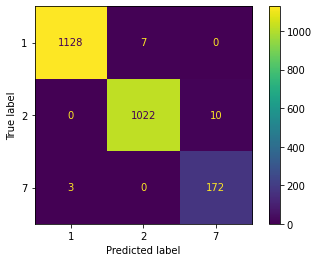

In [30]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, pred_c)
plt.show()

# focal loss CNN

In [39]:

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=0.005,
    restore_best_weights=True,
)


model2 = Sequential([
    layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2,2)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Conv2D(filters=64,kernel_size=(3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    layers.Flatten(),
    layers.Dense(3, activation='softmax')
    ])


model2.compile(optimizer='adam',
              loss=SparseCategoricalFocalLoss(gamma=2),
              metrics=['accuracy'])


model2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=early_stopping,
)


Epoch 1/30
681/681 [==============================] - 5s 7ms/step - loss: 0.1228 - accuracy: 0.9689 - val_loss: 0.0779 - val_accuracy: 0.9890
Epoch 2/30
681/681 [==============================] - 5s 7ms/step - loss: 0.0721 - accuracy: 0.9854 - val_loss: 0.0367 - val_accuracy: 0.9934
Epoch 3/30
681/681 [==============================] - 5s 7ms/step - loss: 0.0768 - accuracy: 0.9864 - val_loss: 0.0913 - val_accuracy: 0.9864
Epoch 4/30
681/681 [==============================] - 5s 7ms/step - loss: 0.0750 - accuracy: 0.9880 - val_loss: 0.1002 - val_accuracy: 0.9868
Epoch 5/30
681/681 [==============================] - 5s 7ms/step - loss: 0.0705 - accuracy: 0.9897 - val_loss: 0.0707 - val_accuracy: 0.9916
Epoch 6/30
681/681 [==============================] - 5s 7ms/step - loss: 0.0584 - accuracy: 0.9912 - val_loss: 0.1028 - val_accuracy: 0.9890
Epoch 7/30
681/681 [==============================] - 5s 7ms/step - loss: 0.0600 - accuracy: 0.9913 - val_loss: 0.0444 - val_accuracy: 0.9941


In [40]:
preds2 = model2.predict(X_test)
lb = LabelBinarizer()
_labels = [0,1,2]
lb.fit(_labels)
pred_c2 = lb.inverse_transform(preds2)

In [41]:
pred_c2[pred_c2==1]=7
pred_c2[pred_c2==0]=1

In [42]:
Counter(pred_c2)

Counter({2: 1034, 1: 1137, 7: 171})

## Matriz de Confusion Focal Loss

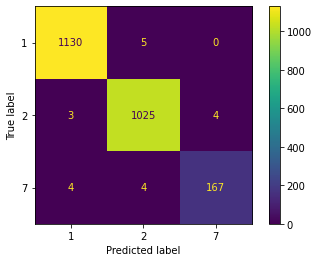

In [43]:
ConfusionMatrixDisplay.from_predictions(y_test, pred_c2)
plt.show()

# Dataset 2

Obtenido de https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset

Para testear descomente la lineas de abajo y modifique el path de C:/Users/Rod/Desktop/T1 deep learning para que sea relativo a su pc... por alguna razon no nos tomo el de la carpeta y por eso tuvimos que hardcodearlo

In [ ]:
# original_dataset_dir = r'C:/Users/Rod/Desktop/T1 deep learning/PetImages'

# # create a folder to store our small sample of images
# base_dir = r'C:/Users/Rod/Desktop/T1 deep learning/cats_and_dogs_small'
# os.mkdir(base_dir)
# train_dir = os.path.join(base_dir, 'train')
# os.mkdir(train_dir)

# test_dir = os.path.join(base_dir, 'test')
# os.mkdir(test_dir)

# train_Cat_dir = os.path.join(train_dir, 'Cat')
# os.mkdir(train_Cat_dir)

# train_Dog_dir = os.path.join(train_dir, 'Dog')
# os.mkdir(train_Dog_dir)

# test_Cat_dir = os.path.join(test_dir, 'Cat')
# os.mkdir(test_Cat_dir)

# test_Dog_dir = os.path.join(test_dir, 'Dog')
# os.mkdir(test_Dog_dir)

In [ ]:
# fnames = ['{}.jpg'.format(i) for i in range(500)]
# for fname in fnames:
#     src = os.path.join(original_dataset_dir + '/Cat', fname)
#     dst = os.path.join(train_Cat_dir, fname)
#     shutil.copyfile(src, dst)
# fnames = ['{}.jpg'.format(i) for i in range(500, 600)]
# for fname in fnames:
#     src = os.path.join(original_dataset_dir + '/Cat', fname)
#     dst = os.path.join(test_Cat_dir, fname)
#     shutil.copyfile(src, dst)
# fnames = ['{}.jpg'.format(i) for i in range(9000)]

# for fname in fnames:
#     src = os.path.join(original_dataset_dir + '/Dog', fname)
#     dst = os.path.join(train_Dog_dir, fname)
#     shutil.copyfile(src, dst)
# fnames = ['{}.jpg'.format(i) for i in range(10000, 12000)]
# print(len(fnames))
# fnames.remove('11702.jpg')
# print(len(fnames))
# for fname in fnames:
#     src = os.path.join(original_dataset_dir + '/Dog', fname)
#     dst = os.path.join(test_Dog_dir, fname)
#     shutil.copyfile(src, dst)

2000
1999


In [46]:
print("total training cat images :", len(os.listdir(train_Cat_dir)))
print("total training dog images :", len(os.listdir(train_Dog_dir)))
print("total test cat images :", len(os.listdir(test_Cat_dir)))
print("total test dog images :", len(os.listdir(test_Dog_dir)))

total training cat images : 500
total training dog images : 9000
total test cat images : 100
total test dog images : 1999


## Creación dataset de entrenamiento/validacion

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.2, horizontal_flip=True,vertical_flip=True,zoom_range=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
                        train_dir,
                        target_size=(150,150),
                        batch_size=20,
                        color_mode='rgb',
                        class_mode='binary',
                        subset='training',
                        )

validation_gen = train_datagen.flow_from_directory(
                        train_dir,
                        target_size=(150,150),
                        batch_size=20,
                        class_mode='binary',
                        color_mode='rgb',
                        subset='validation',
                        
                        )
test_gen = test_datagen.flow_from_directory(
                        test_dir,
                        target_size=(150,150),
                        batch_size=20,
                        color_mode='rgb',
                        class_mode='binary',
                        )

Found 7600 images belonging to 2 classes.
Found 1900 images belonging to 2 classes.
Found 2099 images belonging to 2 classes.


# Desbalance de clases

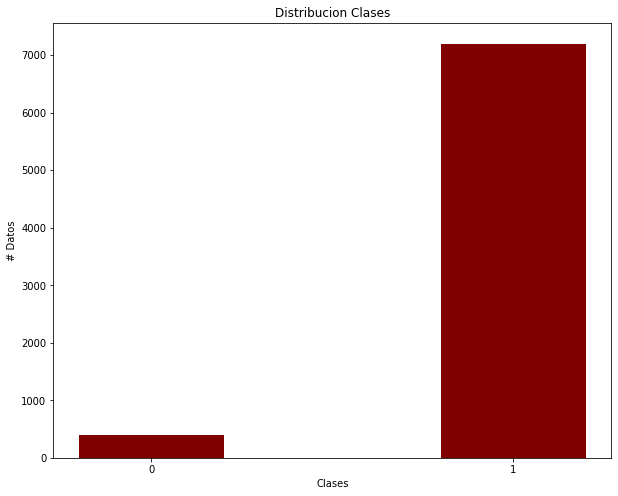

In [48]:
fig = plt.figure(figsize=(10, 8))
plt.bar([str(x) for x in np.unique(train_gen.labels)], Counter(train_gen.labels).values(), color ='maroon',
        width = 0.4)
plt.xlabel("Clases")
plt.ylabel("# Datos")
plt.title("Distribucion Clases")
plt.show()

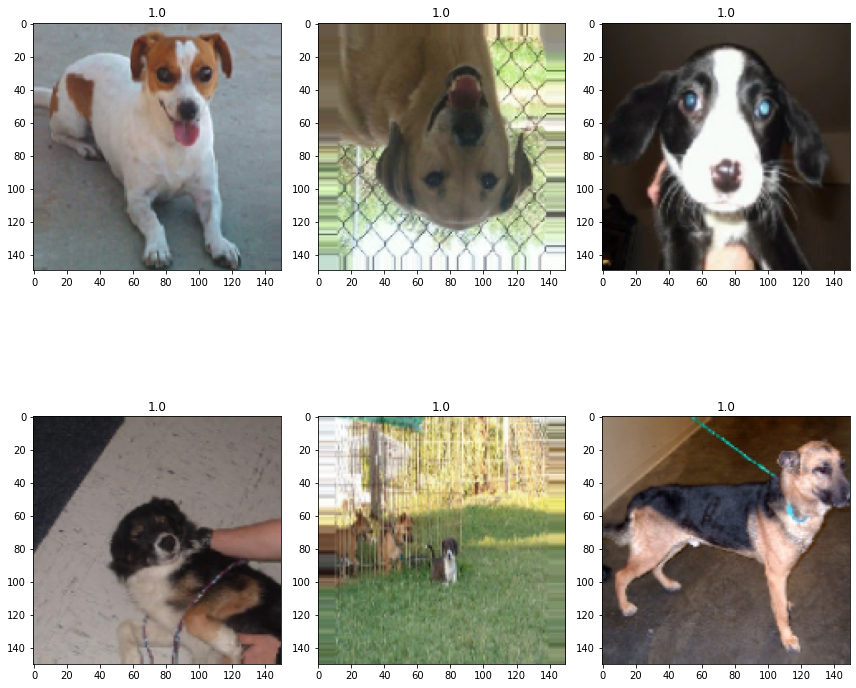

In [49]:
plt.figure(figsize=(12, 12))
for i in range(0, 6):
    plt.subplot(2, 3, i+1)
    for X_batch, Y_batch in train_gen:
        image = X_batch[0]
        plt.title(Y_batch[0])
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

## Peso de clases

In [50]:
class_weight = compute_class_weight(class_weight ='balanced', classes = np.unique(train_gen.labels), y = train_gen.labels)
class_w = {0: class_weight[0], 1: class_weight[1]}

# Weighted model

In [52]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=0.005,
    restore_best_weights=True,
)

model3 = Sequential([
    layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2,2)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Conv2D(filters=64,kernel_size=(3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    layers.Flatten(),
    layers.Dense(1, activation='sigmoid')
    ])


model3.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])


model3.fit(
    train_gen,
    validation_data=validation_gen,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=early_stopping,
    class_weight=class_w
)

Epoch 1/30
380/380 [==============================] - 65s 168ms/step - loss: 10.2388 - accuracy: 0.5376 - val_loss: 3.2852 - val_accuracy: 0.7437
Epoch 2/30
380/380 [==============================] - 56s 147ms/step - loss: 12.1338 - accuracy: 0.5443 - val_loss: 3.8669 - val_accuracy: 0.8858
Epoch 3/30
380/380 [==============================] - 56s 146ms/step - loss: 9.9410 - accuracy: 0.5588 - val_loss: 2.7630 - val_accuracy: 0.7058
Epoch 4/30
380/380 [==============================] - 56s 148ms/step - loss: 7.6145 - accuracy: 0.5978 - val_loss: 2.9735 - val_accuracy: 0.6163
Epoch 5/30
380/380 [==============================] - 56s 147ms/step - loss: 6.5178 - accuracy: 0.5855 - val_loss: 3.5219 - val_accuracy: 0.6484
Epoch 6/30
380/380 [==============================] - 56s 147ms/step - loss: 5.9942 - accuracy: 0.5763 - val_loss: 4.5146 - val_accuracy: 0.3653
Epoch 7/30
380/380 [==============================] - 56s 147ms/step - loss: 4.7529 - accuracy: 0.5586 - val_loss: 3.2508 - val_

## Resultados

In [53]:
pred=model3.predict(test_gen)

In [54]:
pred=np.round(pred)

In [16]:
test_d=test_gen.labels

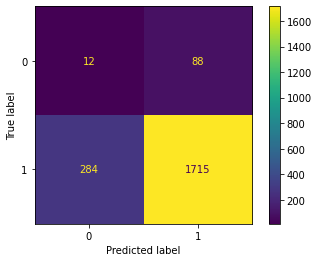

In [56]:
ConfusionMatrixDisplay.from_predictions(test_d, pred)
plt.show()

# Focal loss model

In [7]:
from focal_loss import BinaryFocalLoss

In [58]:
model4 = Sequential([
    layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2,2)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Conv2D(filters=64,kernel_size=(3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    layers.Flatten(),
    layers.Dense(1, activation='sigmoid')
    ])


model4.compile(optimizer='adam',
              loss=BinaryFocalLoss(gamma=5),
              metrics=['accuracy'])


model4.fit(
    train_gen,
    validation_data=validation_gen,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=early_stopping,
)

Epoch 1/30
380/380 [==============================] - 57s 146ms/step - loss: 2.4345 - accuracy: 0.8292 - val_loss: 0.8483 - val_accuracy: 0.9474
Epoch 2/30
380/380 [==============================] - 55s 146ms/step - loss: 0.8749 - accuracy: 0.9453 - val_loss: 0.8483 - val_accuracy: 0.9474
Epoch 3/30
380/380 [==============================] - 55s 145ms/step - loss: 0.8547 - accuracy: 0.9468 - val_loss: 0.9420 - val_accuracy: 0.9389
Epoch 4/30
380/380 [==============================] - 55s 146ms/step - loss: 0.9245 - accuracy: 0.9416 - val_loss: 0.8483 - val_accuracy: 0.9474
Epoch 5/30
380/380 [==============================] - 55s 146ms/step - loss: 0.8483 - accuracy: 0.9474 - val_loss: 0.8483 - val_accuracy: 0.9474
Epoch 6/30
380/380 [==============================] - 56s 146ms/step - loss: 0.8483 - accuracy: 0.9474 - val_loss: 0.8483 - val_accuracy: 0.9474


## Resultados

In [59]:
pred2=model4.predict(test_gen)
pred2=np.round(pred2)

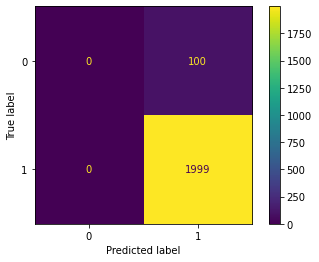

In [60]:
ConfusionMatrixDisplay.from_predictions(test_d, pred2)
plt.show()

# Probando Gamma menor

In [13]:
model5 = Sequential([
    layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2,2)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Conv2D(filters=64,kernel_size=(3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    layers.Flatten(),
    layers.Dense(1, activation='sigmoid')
    ])


model5.compile(optimizer='adam',
              loss=BinaryFocalLoss(gamma=2),
              metrics=['accuracy'])


model5.fit(
    train_gen,
    validation_data=validation_gen,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=early_stopping,
)

Epoch 1/30
380/380 [==============================] - 63s 157ms/step - loss: 1.4252 - accuracy: 0.8786 - val_loss: 0.8448 - val_accuracy: 0.9474
Epoch 2/30
380/380 [==============================] - 58s 152ms/step - loss: 0.8799 - accuracy: 0.9426 - val_loss: 0.8483 - val_accuracy: 0.9474
Epoch 3/30
380/380 [==============================] - 57s 151ms/step - loss: 0.8535 - accuracy: 0.9466 - val_loss: 0.8398 - val_accuracy: 0.9479
Epoch 4/30
380/380 [==============================] - 58s 152ms/step - loss: 0.8482 - accuracy: 0.9474 - val_loss: 4.1035 - val_accuracy: 0.7132
Epoch 5/30
380/380 [==============================] - 59s 155ms/step - loss: 0.8509 - accuracy: 0.9471 - val_loss: 0.8483 - val_accuracy: 0.9474
Epoch 6/30
380/380 [==============================] - 58s 154ms/step - loss: 0.8483 - accuracy: 0.9474 - val_loss: 0.8483 - val_accuracy: 0.9474


## Resultados

In [17]:
pred2=model5.predict(test_gen)
pred2=np.round(pred2)

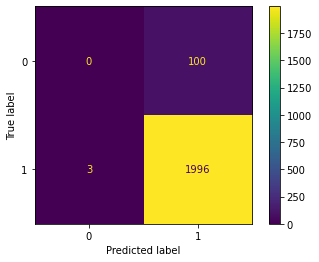

In [18]:
ConfusionMatrixDisplay.from_predictions(test_d, pred2)
plt.show()